**LIBRARIES**

In [1]:
pip install glove-python-binary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Basic Libraries
import pandas as pd 
import numpy as np 
import re
import string

#Specific library
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
nltk.download('wordnet')
nltk.download('omw-1.4')

#Sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.metrics as metrics

#gensim library
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim.test.utils import datapath
from tqdm import tqdm 

#fastText
import fasttext
from fasttext import train_supervised 

#glove
import glove 
from glove import Glove
from glove import Corpus

#Svm classifier libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm

#matplotlib
import matplotlib.pyplot as plt

#seaborn
import seaborn as sns
#xgboost
from xgboost import XGBClassifier

#logistic
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/teframartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/teframartin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ImportError: cannot import name 'LabeledSentence' from 'gensim.models.doc2vec' (/opt/homebrew/lib/python3.10/site-packages/gensim/models/doc2vec.py)

**IMPORT AND CLEAN THE DATA**

In [43]:

#import the stopword list from the spacy library 
#Counter appliation in order to improve the running 
sp = spacy.load('en_core_web_sm')
spacy_stopwords = sp.Defaults.stop_words
stopwords_dict = Counter(spacy_stopwords)
lemmatizer =WordNetLemmatizer()

#cleaning "pipeline"  
def clean_data(text, stopwords, lemmatization):

      #perform casefolding
      text =text.casefold()
      #remove different tags for instance "<user>,<url>" for each twitter
      text = re.sub('<[^<]+?>','', text)
      #remove digits for each twitter
      text = ' '.join(text_ for text_ in text.split() if not text_.isdigit())
      #remove punctuations for each twitter
      text = ' '.join(text_ for text_ in text.split() if text_ not in string.punctuation)
      #remove the tokens length less than 2 
      text = ' '.join(text_ for text_ in text.split() if len(text)>2)
      
      if lemmatization :
          #perform lemmatization
          text = ' '.join(lemmatizer.lemmatize(text_)  for text_ in text.split() )
      
      if stopwords:
          #remove the stopwords
          text = ' '.join([word for word in text.split() if word not in stopwords_dict])
      return text


#Load the data and run the preprocessor pipeline 
class Preprocessor:
    def __init__(self):
        """Init function
        """
    def load_data(preprocessed=True):
        DIRECTORY1 = "../data/train_pos.txt"
        DIRECTORY2 = "../data/train_neg.txt"

        #import the data
        pos_data = pd.read_fwf(DIRECTORY1, header=None, names=["twitter"])
        pos_data["labels"] = 1
        neg_data = pd.read_fwf(DIRECTORY2, header=None, names=["twitter"])
        neg_data["labels"] = 0
        data = pd.concat([pos_data, neg_data], ignore_index=True)
        #print(pos_data.isnull().any(axis=1))
        np.random.seed(500)
        #shuffle the merge data
        data = data.iloc[np.random.permutation(len(data))]
        #remove the nan rows

        #data.dropna(subset = ["twitter"], inplace=True)
        data['twitter']=data['twitter'].apply(lambda x : clean_data(x, stopwords=True,lemmatization=True))
        
        #remove empty lines if any  
        data.dropna(subset = ["twitter"], inplace=True)

        X = data['twitter'].values
        y = data['labels'].values

        return np.array(X), np.array(y)


In [44]:
spacy_stopwords = list(sp.Defaults.stop_words)

In [45]:
stop_words = spacy_stopwords + ['im', 'dont','dunno', 'cant',"'s", 'u', 'x','user','url','rt','lol', '<user>', '<url>']

In [46]:
#import the cleaned data
X, y = Preprocessor.load_data(preprocessed=True)

In [9]:
len(y)

200000

In [10]:
#each sentences to a list of tokens
X_ = pd.DataFrame({'twitter': X})
X_.twitter=X_.twitter.apply(lambda x : [word for word in x.split()])

In [11]:
X_.twitter.values

array([list(['cable', 'sc', 'sc', 'duplex', '62.5', 'multimode', 'fiber', 'patch', 'cable', 'meter', 'blue', 'color-code', '62.5', '...']),
       list(['da', 'flu', 'playing', 'trick', 'wit']),
       list(['drew', 'smallzy', 'like', 'asked', "haven't", 'seen']), ...,
       list(['text', 'device']),
       list(['think', 'paid', 'commission', 'new', 'instagram', 'follower', ':p', 'imma', 'hard', 'weather', 'crap']),
       list(["he's", 'friend', 'attest', 'lost', 'sleep', 'cut', 'originally', '6kwd', 'piece'])],
      dtype=object)

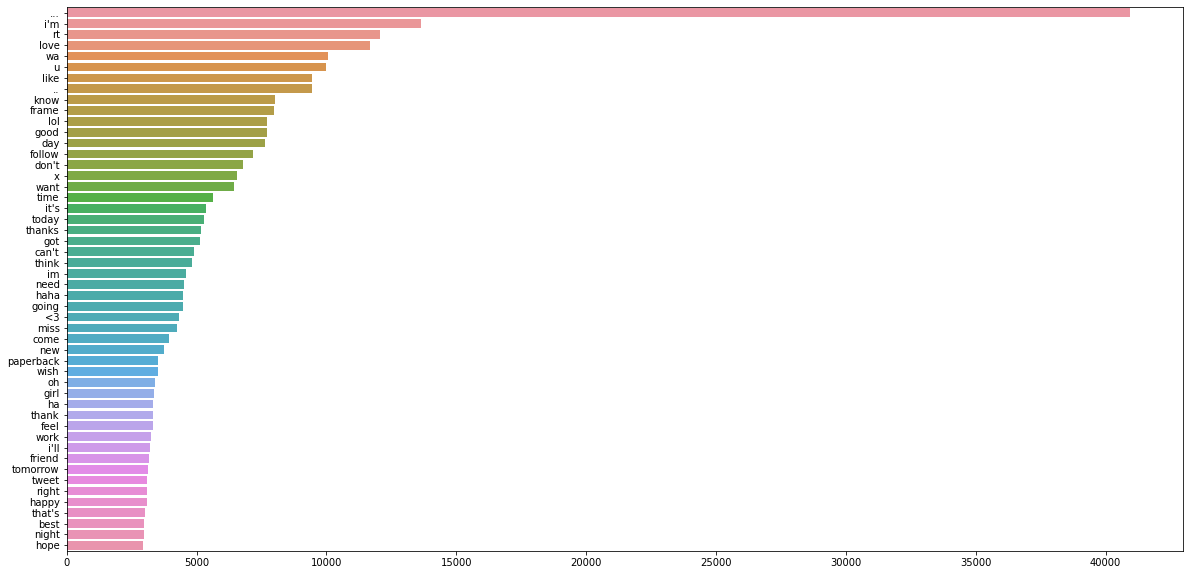

In [12]:
#visualize the common words
flat_list = [item for sublist in X_.twitter.values for item in sublist]

counter = Counter(flat_list)
most = counter.most_common()
x = []
y_ = []
for word,count in most[:50]:
        x.append(word)
        y_.append(count)

plt.figure(figsize = (20, 10))

sns.barplot(x = y_,y = x)
plt.show()
#we need more preprocessing 

**FINDING THE BEST TEXT REPRESENTATIVE TECHNIQUE**

***TEXT VECTORIZATION TECHNIQUES***

**TF-IDF**

In [13]:
#TF-IDF text vectorization
#represent sentence by tf-idf score but fails to suggest a relation between two words

#calculate the TF-IDF matrix (so the scores of each word for every twitter in the entire dataset)
#so we do not want the terms that appears in more than 60% of doocuments we are also applying l2 normalization over the columns 
tf_idf_vectorizer = TfidfVectorizer(max_df=0.7, norm='l2') 
TF_IDF_X = tf_idf_vectorizer.fit_transform(X) # represent our train data in the vector form of each sentence
TF_IDF_X.shape

(200000, 93474)

**Bag of Words**

In [14]:
#Bag of Words text vectorization
bow_vectorizer = CountVectorizer(max_df=0.70)
bow_X = bow_vectorizer.fit_transform(X)# represent our train data in the vector form of each sentence
bow_X.shape

(200000, 93474)

In [15]:
#in the two above baseline text vectorization we represent our tweets as documents of the entire word(vector) appearances over the dataset

***WORD EMBEDDINGS TECHNIQUES***

In [16]:
# to represent sentences better so to keep the relations of words within a sentence we apply word embeddings techniques

**Word2Vec**

In [17]:
#each sentences to a list of tokens
X_ = pd.DataFrame({'twitter': X})
X_.twitter=X_.twitter.apply(lambda x : [word for word in x.split()])

In [18]:
#taking the mean of all words for representing a document/tweet

def word_vector(tokens, size, method):
    vec = np.zeros(size).reshape((1, size))
    count = 0

    if method=='word2vec':
      for word in tokens:
          try:
              vec += Word2vec[word].reshape((1, size))
              count += 1.
          except KeyError:  # handling the case where the token is not in vocabulary
              continue
    if method=='doc2vec':
      for word in tokens:
          try:
              vec += Doc2vec[word].reshape((1, size))
              count += 1.
          except KeyError:  # handling the case where the token is not in vocabulary
              continue

    if method=='glove':
      for word in tokens:
          try:
              vec += glove_model.word_vectors[glove_model.dictionary[word]].reshape((1, size))
              count += 1.
          except KeyError:  # handling the case where the token is not in vocabulary
              continue
    if method=='fasttext':
      for word in tokens:
          try:
              vec += fast_Text_model[word].reshape((1, size))
              count += 1.
          except KeyError:  # handling the case where the token is not in vocabulary
              continue
    if count != 0:
        vec /= count
    return vec

In [19]:
#define the Word2Vec 
Word2vec = gensim.models.Word2Vec(
            X_.twitter,
            size=200, # desired no. of features/independent variables , try differents sizes of words size representation of each tweet
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

In [20]:
Word2vec.train(X_.twitter, total_examples= len(X_.twitter), epochs=10)#maybe we should run cross validation 

(12999823, 14689820)

In [21]:
Word2vec.wv.most_similar(positive="football")#the positive synonums of the token "football" just for instance

[('uefa', 0.6234691143035889),
 ('fernando', 0.6177797913551331),
 ('torres', 0.6089628338813782),
 ('videogame', 0.6037684679031372),
 ('gridiron', 0.5912767052650452),
 ('arross', 0.5808979868888855),
 ('bandroom', 0.5785493850708008),
 ('#kkpsi', 0.5687294006347656),
 ('mkayy', 0.5622963905334473),
 ('#ucl', 0.5584178566932678)]

In [22]:

#create a vector of size 200 for each sentence 
wordvec_X = np.zeros((len(X_.twitter.values), 200)) 
for i in range(len(X_.twitter.values)):
    wordvec_X[i,:] = word_vector(X_.twitter.values[i], 200,'word2vec')
wordvec_X.shape

<ipython-input-18-927ab7d944eb>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += Word2vec[word].reshape((1, size))


(200000, 200)

In [23]:
wordvec_X

array([[ 0.02603961,  0.31948196,  0.45198683, ...,  0.02944654,
         0.21285176,  0.20344445],
       [-0.22222865,  0.10158875, -0.1419979 , ..., -0.15416055,
        -0.04212153,  0.16047763],
       [-0.06553069,  0.03477473, -0.10999584, ..., -0.16592478,
        -0.0259028 ,  0.28746829],
       ...,
       [ 0.09820805,  0.27447108,  0.08206907, ..., -0.1785894 ,
         0.15647801,  0.19957394],
       [ 0.00525134,  0.08018335, -0.31118347, ..., -0.27788934,
         0.00969605,  0.26944401],
       [ 0.0455983 ,  0.2244025 , -0.22113024, ..., -0.38807585,
        -0.03880239,  0.20693999]])

**Doc2Vec**

In [24]:
#add a unique label to each tweet using Labeled Sentence in order to run the Doc2vec text vectorization 
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

X_labeled = add_label(X_.twitter)

<ipython-input-24-fa5131ed851e>:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


In [25]:
#define the Doc2Vec
#maybe we should run the cross validation
Doc2vec = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=2, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

Doc2vec.build_vocab([i for i in tqdm(X_labeled)])

Doc2vec.train(X_labeled, total_examples= len(X_labeled), epochs=10)


100%|██████████| 200000/200000 [00:00<00:00, 2545759.35it/s]


In [26]:
#create the vectors of each tweet using the doc2vec model

doc2vec_X = np.zeros((len(X_.twitter.values), 200)) 
for i in range(len(X_.twitter.values)):
    doc2vec_X[i,:] = word_vector(X_.twitter.values[i], 200,'doc2vec')
doc2vec_X.shape

(200000, 200)

In [27]:
doc2vec_X

array([[-0.58617517, -0.19242191, -0.81955043, ...,  0.33660533,
         0.29979427,  0.03378139],
       [ 0.52194807, -0.65578076, -0.68942839, ...,  0.0340919 ,
         0.03221127,  0.47808241],
       [-0.15754838,  0.05427129,  0.17049635, ...,  0.27353916,
        -0.09951616,  0.34529723],
       ...,
       [ 0.5554958 ,  0.08452889, -0.8047428 , ...,  0.70160317,
         0.79194453, -0.66672337],
       [ 0.0690829 ,  0.60621805, -0.68613628, ...,  0.00409198,
        -0.30207484, -0.10451946],
       [ 0.30573508, -0.22097171, -0.25562016, ...,  0.63344157,
         0.08103908, -0.39271296]])

**GloVe**

In [28]:
# instantiate the corpus
corpus = Corpus() 

# this will create the word co occurence matrix 
corpus.fit(X_.twitter, window=10)

In [29]:
# instantiate the model
glove_model = Glove(no_components=200, learning_rate=0.1)

# and fit over the corpus matrix
glove_model.fit(corpus.matrix, epochs=10, no_threads=4)

# finally we add the vocabulary to the model
glove_model.add_dictionary(corpus.dictionary)

In [30]:
#create the vectors of each tweet using the glove model by just averaging the words for each sentence
glove_X = np.zeros((len(X_.twitter.values), 200)) 
for i in range(len(X_.twitter.values)):
    glove_X[i,:] = word_vector(X_.twitter.values[i], 200,'glove')
glove_X.shape

(200000, 200)

In [31]:
glove_X

array([[ 0.07806913, -0.04329496,  0.01321094, ..., -0.0947564 ,
         0.06576234, -0.08760712],
       [ 0.00905418, -0.03182365,  0.02870497, ..., -0.08720629,
         0.07391743, -0.01745886],
       [ 0.02096238,  0.05213926, -0.05125712, ..., -0.14571882,
         0.10159686, -0.05975586],
       ...,
       [ 0.05111603, -0.17195545,  0.1249349 , ..., -0.12723215,
         0.08606703, -0.07972915],
       [ 0.04429082, -0.10394958,  0.01894726, ..., -0.15212264,
         0.15846224,  0.03944534],
       [-0.00192359, -0.06419596,  0.01521721, ..., -0.13503463,
         0.10965892,  0.01246723]])

**FastText**

In [32]:
#train our fastText model for word embeddings 

embedding_size = 200
window_size = 5
min_word = 2
down_sampling = 1e-2
 
fast_Text_model = gensim.models.FastText(
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      iter=100)

fast_Text_model.build_vocab(sentences=X_.twitter)
total_words = fast_Text_model.corpus_total_words
fast_Text_model.train(sentences=X_.twitter, total_words=total_words, epochs=10)

In [33]:
#create the vectors of each tweet using the fasttext model by just averaging the words for each sentence

fastText_X = np.zeros((len(X_.twitter.values), 200)) 
for i in range(len(X_.twitter.values)):
    fastText_X[i,:] = word_vector(X_.twitter.values[i], 200,'fasttext')
fastText_X.shape

<ipython-input-18-927ab7d944eb>:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += fast_Text_model[word].reshape((1, size))


(200000, 200)

In [34]:
fastText_X

array([[ 0.09472805, -0.39677169,  0.09416173, ...,  0.06617242,
        -0.05497433,  0.38854739],
       [-0.0095522 ,  0.18390504,  0.07974035, ..., -0.116596  ,
         0.24930438,  0.05105175],
       [-0.04010312,  0.05145881, -0.1449402 , ..., -0.07855349,
         0.05217977,  0.12901319],
       ...,
       [ 0.25716037,  0.04820671,  0.00387697, ...,  0.0065099 ,
        -0.11720283, -0.00180997],
       [ 0.05492487, -0.14253653, -0.0655574 , ..., -0.15353128,
         0.04785913,  0.15648126],
       [ 0.119001  ,  0.10361731, -0.08331116, ..., -0.04935774,
         0.00493375,  0.18169274]])

In [35]:

vectors = {'W2v': wordvec_X, 'D2v': doc2vec_X, 'Glo': glove_X,  'Fst': fastText_X}


In [37]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**RUN DIFFERENT MODELS**

In [38]:
#split our small(200000 tweet) dataset to a training ,validation and testing set for each of our representations 

X_W2v=[X_train_W2v, X_test_W2v, Y_train_W2v, Y_test_W2v] = train_test_split(wordvec_X, y, test_size = .25, random_state = 18)
X_D2v=[X_train_D2v, X_test_D2v, Y_train_D2v, Y_test_D2v] = train_test_split(doc2vec_X, y, test_size = .25, random_state = 18)
X_Glo=[X_train_Glo, X_test_Glo, Y_train_Glo, Y_test_Glo] = train_test_split(glove_X,   y, test_size = .25, random_state = 18)
X_Fst=[X_train_Fst, X_test_Fst, Y_train_Fst, Y_test_Fst] = train_test_split(fastText_X, y, test_size = .25, random_state = 18)

**Logistic Regression**

In [39]:
#let's try logistic regression as baseline 

results=[]
for index,vectors in enumerate([X_W2v,X_D2v,X_Glo,X_Fst]):
    lreg = LogisticRegression(solver='lbfgs') 
    lreg.fit(vectors[0], vectors[2]) # try for each vector representation
    prediction = lreg.predict_proba(vectors[1]) # predicting on the validation set 
    prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.3 than 1 else 0 
    prediction_int = prediction_int.astype(np.int) 
    results.append(f1_score(vectors[3], prediction_int, average='weighted'))
    print(metrics.classification_report(vectors[3], prediction_int,  digits=5))

<ipython-input-39-a41261a09b80>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


              precision    recall  f1-score   support

           0    0.77248   0.74353   0.75773     24978
           1    0.75322   0.78139   0.76705     25022

    accuracy                        0.76248     50000
   macro avg    0.76285   0.76246   0.76239     50000
weighted avg    0.76284   0.76248   0.76239     50000



<ipython-input-39-a41261a09b80>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


              precision    recall  f1-score   support

           0    0.76076   0.73713   0.74876     24978
           1    0.74548   0.76860   0.75687     25022

    accuracy                        0.75288     50000
   macro avg    0.75312   0.75287   0.75281     50000
weighted avg    0.75312   0.75288   0.75282     50000



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-39-a41261a09b80>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/re

              precision    recall  f1-score   support

           0    0.71545   0.74117   0.72808     24978
           1    0.73201   0.70574   0.71863     25022

    accuracy                        0.72344     50000
   macro avg    0.72373   0.72346   0.72336     50000
weighted avg    0.72374   0.72344   0.72336     50000

              precision    recall  f1-score   support

           0    0.77466   0.74542   0.75976     24978
           1    0.75509   0.78355   0.76906     25022

    accuracy                        0.76450     50000
   macro avg    0.76488   0.76448   0.76441     50000
weighted avg    0.76487   0.76450   0.76441     50000



<ipython-input-39-a41261a09b80>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


In [40]:
results#f1 scores

[0.7623928175697576,
 0.7528170841187847,
 0.7233551385830764,
 0.7644122900200626]

**SVM**

In [ ]:
#try for all vector represenations

svm_results=[]
for index,vectors in enumerate([X_W2v,X_D2v,X_Glo,X_Fst]):
  svc = svm.SVC(kernel='rbf', C=1).fit(vectors[0], vectors[2])#Fasttext, glovec, word2vec, doc2vec
  y_pred =svc.predict(vectors[1]) # 
  print(metrics.classification_report(vectors[3], y_pred,  digits=5))
  svm_results.append(f1_score(vectors[3], prediction_int, average='weighted'))

In [ ]:
svm_results

In [ ]:
#SVM
#we will try to train SVM using best X/vector presentation of our tweets  which is from the above results the Glove
# Define the parameters to tune the model

parameters = { 
    'C': [0.1,1.0, 10.0],
    'gamma': [1, 'auto', 'scale']
}

# Tune yyperparameters  using Grid Search and a SVM model
def SVM(X_train,Y_train):
  model = GridSearchCV(SVC(kernel='rbf'), parameters,scoring="roc_auc", cv=5, n_jobs=-1).fit(X_train, Y_train)
  return model#took more than 2 hours to train only using the FastText vectors representations

#we have to run a svm for each representations to see if we will have different results 
model_svm=SVM(X_train_Glo,Y_train_Glo)
y_pred = model_svm.predict(Y_test_Glo) # 
print(metrics.classification_report(Y_test_Glo, y_pred,  digits=5))


In [ ]:
plot_confussion_matrix(Y_test_Glo, y_pred)
plot_roc_curve(Y_test_Glo, y_pred)
#run svm for all the above representations 

**XGBOOST**

In [ ]:
#XGBoost
#we will try to train using the 6 different X presentation of our tweets so the Word2Vec, Doc2Vec, Glove, FastText
#and then we will try to tune the best xgboost model for the best vector representation
xgboost_results=[]
for index,vectors in enumerate([X_W2v,X_D2v,X_Glo,X_Fst]):
  xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(vectors[0], vectors[2])
  prediction = xgb_model.predict(vectors[1])
  print(metrics.classification_report(vectors[3], prediction,  digits=5))
  xgboost_results.append(f1_score(vectors[3], prediction_int, average='weighted'))

In [ ]:
xgboost_results